In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

In [3]:
plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rc('legend',fontsize=15)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['font.family'] = 'Times New Roman'

In [4]:
# lgMh_full = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"])
# red_full = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["redshift"])
# halo_masses = np.linspace(8,12,100) # just for the model

In [5]:
lgMh_full = np.vstack(np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["mass"])
red_full = np.vstack(np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["redshift"])
halo_masses = np.linspace(8,12,100) # just for the model

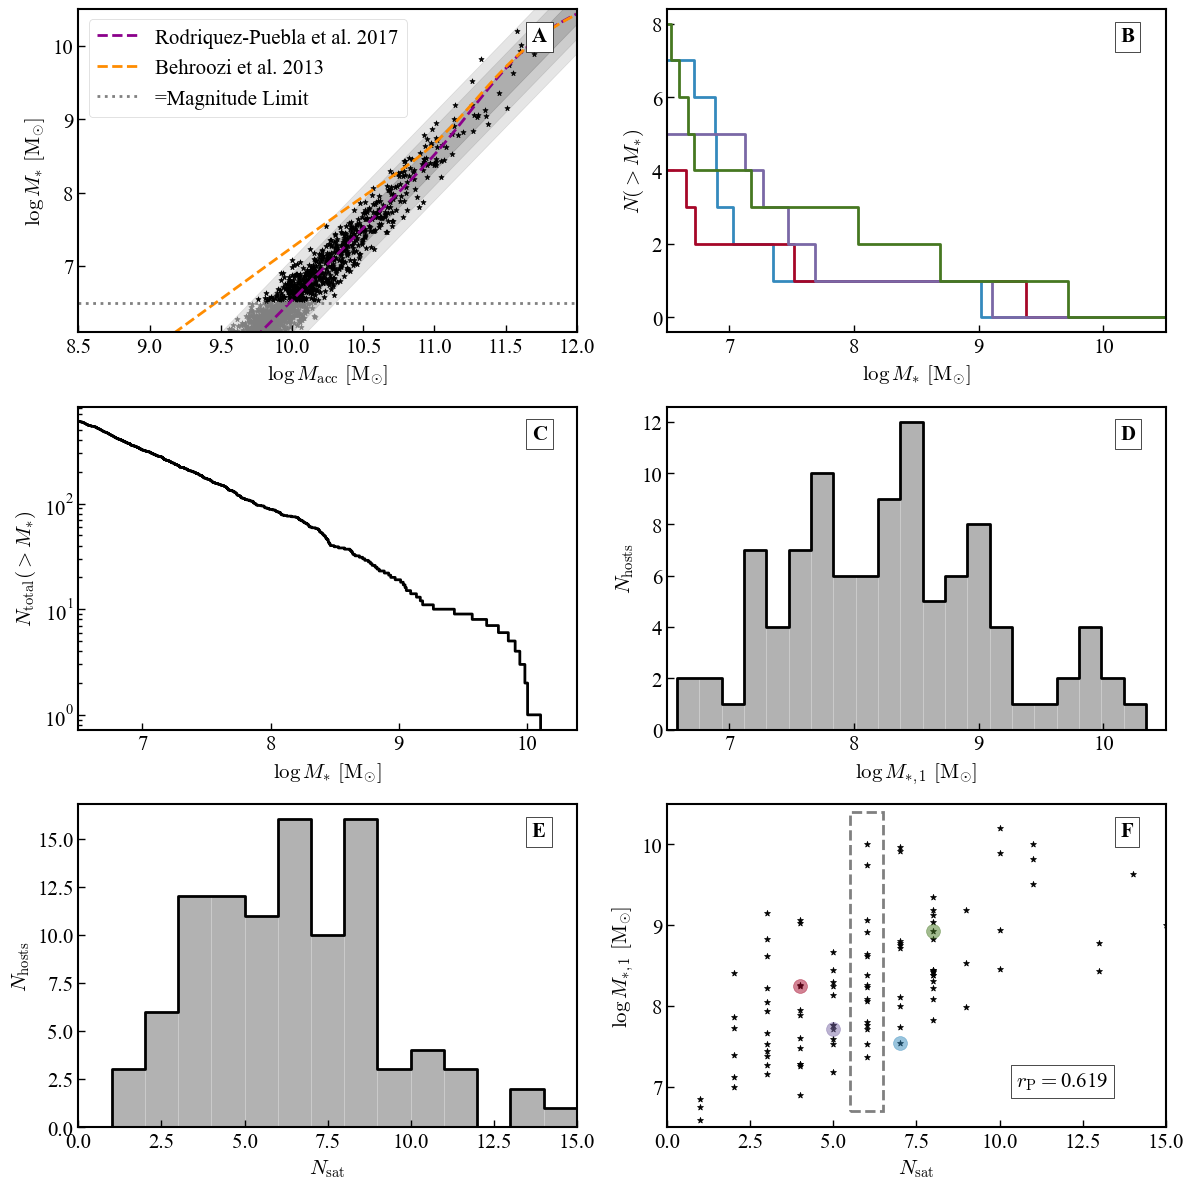

In [6]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

colorpick="k"

theta = [10.5, 2.0, 0.2, 0, 0, 0]
theta_det = theta[:2] + [0, 0] + theta[4:]
sigma = theta[2] + theta[3]*(halo_masses-12)

lgMs_full = jsm_SHMR.general(theta, lgMh_full, red_full, 1)
det = jsm_SHMR.general(theta_det, halo_masses, 0, 1)

lgMh_example = lgMh_full[0:100]
lgMs_example = lgMs_full[0:100]
stat = jsm_stats.SatStats_D(lgMs_example, min_mass=6.5)

ax1.fill_between(halo_masses, det - sigma, det + sigma, color=colorpick, alpha=0.15)
ax1.fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=colorpick, alpha=0.1)
ax1.fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=colorpick, alpha=0.1)

above_limit = lgMs_example.flatten() > 6.5
ax1.scatter(lgMh_example.flatten()[above_limit], lgMs_example.flatten()[above_limit], marker="*", s=15, color=colorpick)
ax1.scatter(lgMh_example.flatten()[~above_limit], lgMs_example.flatten()[~above_limit], marker="*", s=15, color="grey")


ax1.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses), color="darkmagenta", ls="--", label="Rodriquez-Puebla et al. 2017")
ax1.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses), color="darkorange", ls="--", label="Behroozi et al. 2013")
ax1.axhline(6.5, color="grey", ls=":", label="=Magnitude Limit")
ax1.set_xlim(8.5,12)
ax1.set_ylim(6.1,10.5)
ax1.set_ylabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
ax1.set_xlabel("$\log M_{\mathrm{acc}}\ [\mathrm{M}_{\odot}]$")
ax1.legend()

rand = np.random.randint(0,100,4)
for i in rand:
    high = np.column_stack([np.array([10.5]*stat.mass_rank.shape[0]), stat.mass_rank])
    low = np.column_stack([np.array([6.5]*high.shape[0]), np.sort(high)])
    ax2.step(low[i][~np.isnan(low[i])][::-1], np.append(np.arange(stat.Nsat_perhost[i]+1), stat.Nsat_perhost[i]), where="mid")
    ax6.scatter(stat.Nsat_perhost[i], stat.maxmass[i], s=100, marker="o", zorder=10, alpha=0.5)

ax2.set_ylabel("$N (>  M_{*})$")
ax2.set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
ax2.set_xlim(6.5,10.5)

total = np.sort(stat.mass_rank.flatten())[~np.isnan(np.sort(stat.mass_rank.flatten()))]
ax3.step(total, np.arange(0, total.shape[0])[::-1], color=colorpick, where="mid")
ax3.set_ylabel("$ N_{\mathrm{total}} (>  M_{*})$")
ax3.set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
ax3.set_yscale("log")
ax3.set_xlim(6.5)

max_mass_bins = np.linspace(6.4, 10.7, 25)
counts, bincenters = jsm_stats.count(stat.maxmass, max_mass_bins, return_bins=True)
ax4.step(bincenters, counts, where="mid", color=colorpick)
ax4.hist(stat.maxmass, max_mass_bins, color=colorpick, alpha=0.3, edgecolor="white")
ax4.set_xlabel("$\log M_{*,1}\ [\mathrm{M}_{\odot}]$")
ax4.set_ylabel("$N_{\mathrm{hosts}}$")
ax4.set_xlim(6.5,10.5)

Nsat_bins = np.linspace(0, 30, 31)
counts, bincenters = jsm_stats.count(stat.Nsat_perhost, Nsat_bins, return_bins=True)
ax5.step(bincenters, counts, where="mid", color=colorpick)
ax5.hist(stat.Nsat_perhost, bins=Nsat_bins, color=colorpick, alpha=0.3, edgecolor="white")
ax5.set_xlabel("$N_{\mathrm{sat}}$")
ax5.set_ylabel("$N_{\mathrm{hosts}}$")
ax5.set_xlim(0,15)

rect = patches.Rectangle((5.5, 6.7), 1, 3.7, linewidth=2, edgecolor='grey', facecolor="None", ls="--")
ax6.scatter(stat.Nsat_perhost, stat.maxmass, color=colorpick, s=20, marker="*")
ax6.add_patch(rect)
ax6.text(10.5, 7, "$r_{\mathrm{P}} =$"+f"{stat.correlation:.3f}", fontsize=15,  bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
ax6.set_ylabel("$\log M_{*,1}\ [\mathrm{M}_{\odot}]$")
ax6.set_xlabel("$N_{\mathrm{sat}}$")
ax6.set_xlim(0,15)
ax6.set_ylim(6.5,10.5)


ax1.text(0.91, 0.9, "A", transform=ax1.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
ax2.text(0.91, 0.9, "B", transform=ax2.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
ax3.text(0.91, 0.9, "C", transform=ax3.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
ax4.text(0.91, 0.9, "D", transform=ax4.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
ax5.text(0.91, 0.9, "E", transform=ax5.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
ax6.text(0.91, 0.9, "F", transform=ax6.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))

plt.tight_layout()
plt.savefig("../../../paper_1/figures/updated/tutuorial.pdf", bbox_inches="tight")
plt.show()

# ax1.plot(x, y)
# ax3.plot(x, y**2, 'tab:orange')
# ax3.plot(x, -y, 'tab:green')
# ax4.plot(x, -y**2, 'tab:red')